In [1]:
import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import cv2
import uuid
import time
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import xmltodict
import glob
import xml.etree.ElementTree as ET
import random as rnd
import splitfolders
import easyocr
import PIL
import copy

from pathlib import Path
from sklearn.model_selection import train_test_split
from collections import Counter
from PIL import Image
from tqdm.auto import tqdm
# from GPUtil import showUtilization as gpu_usage
# from numba import cuda
from timeit import default_timer as timer

import torch

import matplotlib
# matplotlib.use('TkAgg')

from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from matplotlib import patches as mpatches

### Kaggle에서 얻은 Dataset을 torch를 이용하는 YOLOv5 모델에 적용하기 위하여 Datafram을 생성하여 정리

In [2]:
dataset = {
            "file":[],
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],
            "xmax":[],
            "ymax":[]
           }

In [3]:
path_annotations="../data/annotations/*.xml" 

for item in glob.glob(path_annotations):
    tree = ET.parse(item)
    
    for elem in tree.iter():
        if 'filename' in elem.tag:
            filename=elem.text
        elif 'width' in elem.tag:
            width=int(elem.text)
        elif 'height' in elem.tag:
            height=int(elem.text)
        elif 'xmin' in elem.tag:
            xmin=int(elem.text)
        elif 'ymin' in elem.tag:
            ymin=int(elem.text)
        elif 'xmax' in elem.tag:
            xmax=int(elem.text)
        elif 'ymax' in elem.tag:
            ymax=int(elem.text)
            
            dataset['file'].append(filename)
            dataset['width'].append(width)
            dataset['height'].append(height)
            dataset['xmin'].append(xmin)
            dataset['ymin'].append(ymin)
            dataset['xmax'].append(xmax)
            dataset['ymax'].append(ymax)
        
classes = ['license']

In [4]:
df=pd.DataFrame(dataset)
df

,file,width,height,xmin,ymin,xmax,ymax
0,Cars213.png,400,300,150,160,233,194
1,Cars207.png,400,478,254,229,372,264
2,Cars398.png,400,300,72,139,196,222
3,Cars367.png,450,299,224,161,382,222
4,Cars401.png,400,300,158,223,238,240
...,...,...,...,...,...,...,...
466,Cars418.png,400,225,99,70,303,155
467,Cars395.png,400,301,241,182,288,205
468,Cars381.png,400,225,65,131,147,155
469,Cars222.png,400,230,178,158,235,170


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471 entries, 0 to 470
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    471 non-null    object
 1   width   471 non-null    int64 
 2   height  471 non-null    int64 
 3   xmin    471 non-null    int64 
 4   ymin    471 non-null    int64 
 5   xmax    471 non-null    int64 
 6   ymax    471 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 25.9+ KB


### 이미지와 Annotation을 조합하여 그림

In [6]:
def drawImageWithBox(name):
    img = cv2.imread(f'../data/images/{name}')
    
    x_min, y_min, x_max, y_max = list(df.iloc[df[df.file == name].index[0], 3:])
    
    cv2.rectangle(img, pt1=(x_min,y_min), pt2=(x_max,y_max), color=(0,255,0), thickness=2)
    
    plt.figure(figsize=(12,12))
    plt.imshow(img, cmap='gray')

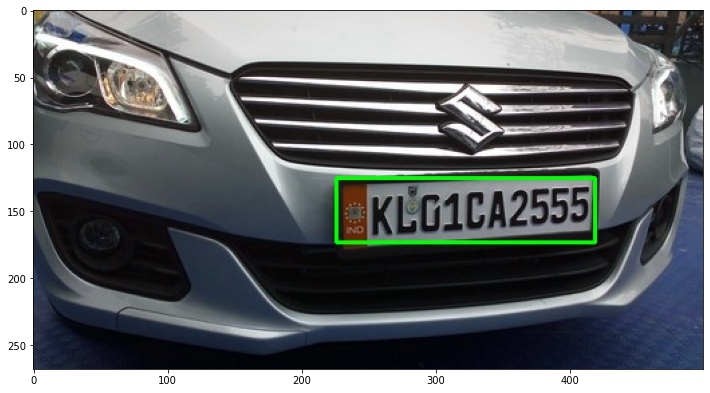

In [7]:
drawImageWithBox('Cars0.png')

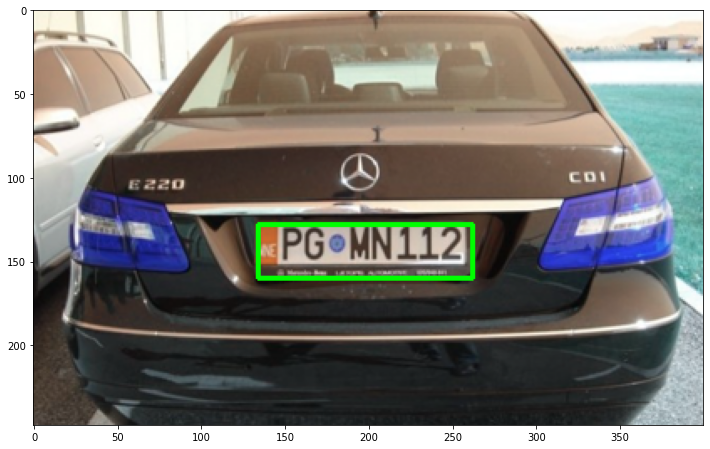

In [8]:
drawImageWithBox('Cars1.png')

### 주어진 이미지와 Annotation을 이용하여 Label 파일 생성

In [9]:
x_pos = []
y_pos = []
frame_width = []
frame_height = []

labels_path_name = "../data/labels"
labels_path = Path(labels_path_name)

labels_path.mkdir(parents=True, exist_ok=True)

save_type = 'w'

for i, row in enumerate(df.iloc):
    current_filename = str(row.file[:-4])
    
    width, height, xmin, ymin, xmax, ymax = list(df.iloc[i][1:7])
    
    x=(xmin+xmax)/2/width
    y=(ymin+ymax)/2/height
    width=(xmax-xmin)/width
    height=(ymax-ymin)/height
    
    x_pos.append(x)
    y_pos.append(y)
    frame_width.append(width)
    frame_height.append(height)
    
    txt = '0' + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + '\n'
    
    if i > 0:
        previous_filename = str(df.file[i-1][:-4])
        save_type='a+' if current_filename == previous_filename else 'w'
    
    
    with open(f'{labels_path_name}/{current_filename}.txt', save_type) as f:
        f.write(txt)
        
        
df['x_pos']=x_pos
df['y_pos']=y_pos
df['frame_width']=frame_width
df['frame_height']=frame_height

df[df.file == 'Cars0.png']

,file,width,height,xmin,ymin,xmax,ymax,x_pos,y_pos,frame_width,frame_height
165,Cars0.png,500,268,226,125,419,173,0.645,0.55597,0.386,0.179104


### 정리된 데이터를 Train, Validation 데이터로 분리

In [10]:
input_folder = Path("../data")
output_folder = Path("../yolov5-data/data")
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2),
    group_prefix=None
)
print("Moving files finished.")

Copying files: 1299 files [00:01, 912.84 files/s] 

Moving files finished.


### Torch로 훈련하기 위하여 yaml 파일 생성

In [11]:
import yaml

yaml_file = '../yolov5/plates.yaml'

yaml_data = dict(
    path = "data",
    train = "train",
    val = "val",
    nc = len(classes),
    names = classes
)

with open(yaml_file, 'w') as f:
    yaml.dump(yaml_data, f, explicit_start = True, default_flow_style = False)

### 생성된 yaml 파일을 이용하여 학습 시작

In [85]:
start_time = timer()

!cd ../yolov5 && python train.py --workers 4 --img 640 --batch 16 --epochs 100 --data "data/plates.yaml" --weights yolov5s.pt --cache

end_time = timer()

print(f'Training time: {(end_time - start_time):.2f}')

train: weights=yolov5s.pt, cfg=, data=data/plates.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=4, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-228-g6ae3dff Python-3.8.13 torch-1.13.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.

      32/99         0G    0.03071   0.007567          0         17        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.895      0.887      0.898      0.484

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      33/99         0G    0.03022   0.007269          0         32        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.934      0.874      0.906       0.48

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      34/99         0G    0.03088   0.008102          0         29        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.921      0.887      0.921        0.5

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      35/9

      57/99         0G    0.02452   0.006972          0         24        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.903      0.845      0.898      0.502

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      58/99         0G    0.02326   0.006685          0         20        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.917      0.906      0.926      0.497

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      59/99         0G    0.02378   0.006489          0         21        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.865      0.897      0.897      0.474

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      60/9

      82/99         0G    0.01867   0.005886          0         17        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.964      0.856      0.927      0.505

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      83/99         0G    0.01821   0.005891          0         24        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.963      0.856      0.925        0.5

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      84/99         0G    0.01917   0.005871          0         20        640: 1
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.963      0.856      0.921      0.499

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      85/9

### 학습된 모델을 이용하여 Validation

In [3]:
!cd ../yolov5 && python val.py --workers 4 --data "data/plates.yaml"  --weights '../yolov5/runs/train/exp9/weights/best.pt'

val: data=data/plates.yaml, weights=['../yolov5/runs/train/exp9/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=4, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-235-g75728bb Python-3.8.13 torch-1.13.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/Users/okchuri/project/codestates/CP1/yolov5/data/val/labels.cach
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.912      0.866      0.922      0.525
Speed: 2.1ms pre-process, 353.8ms inference, 0.6ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp2


In [4]:
!cd ../yolov5 && python val.py --workers 4 --data "data/plates.yaml"  --weights '../yolov5/runs/train/exp9/weights/best.pt'

val: data=data/plates.yaml, weights=['../yolov5/runs/train/exp9/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=4, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.2-235-g75728bb Python-3.8.13 torch-1.13.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning '/Users/okchuri/project/codestates/CP1/yolov5/data/val/labels.cach
                 Class     Images  Instances          P          R      mAP50   
                   all         87         97      0.912      0.866      0.922      0.525
Speed: 1.8ms pre-process, 353.5ms inference, 0.6ms NMS per image at shape (32, 3, 640, 640)
Results saved to runs/val/exp3


### Tensorboard를 이용하여 학습/검증 결과 확인

In [ ]:
!tensorboard --logdir ../yolov5/runs/train


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)


### 학습된 모델 불러와서 실제 활용

In [12]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path = '../yolov5/runs/train/exp9/weights/best.pt', force_reload=False)

Using cache found in /Users/okchuri/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-9 Python-3.8.13 torch-1.13.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


### 해당 모델에서 MPS(Metal Performance Shaders)를 사용할 수 있도록 설정

In [13]:
model.to('mps')

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

### 이미지를 불러와 모델을 통하여 번호판 인식을 잘 하는지 확인

In [14]:
img = cv2.imread('../data/images/Cars0.png')

In [15]:
results = model(img)

In [16]:
labels, coordinates = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]

In [17]:
width, height = img.shape[1], img.shape[0]

In [18]:
detections = [['None', [0, 0], 0] for n in range(5)]

/var/folders/d3/rg33x5mx21z57d1fcv44v7qr0000gn/T/ipykernel_2104/2852757066.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


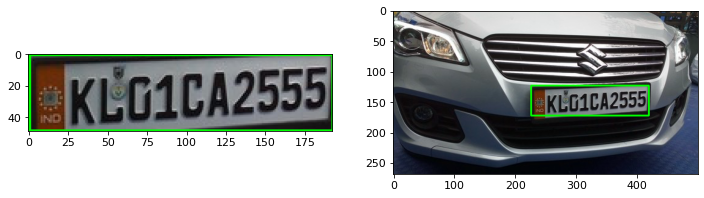

In [19]:
for i in range(len(labels)):
    row = coordinates[i]
    
    x1, y1, x2, y2 = int(row[0].item()*width), int(row[1].item()*height), int(row[2].item()*width), int(row[3].item()*height)
    
    plate_crop = img[int(y1):int(y2), int(x1):int(x2)]
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    fig = plt.figure(figsize=(12, 12))
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(plate_crop, cmap='gray')
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(img, cmap='gray')
    
    plt.show()

### 번호판 인식률을 올리기 위하여 Gray Scale로 변경

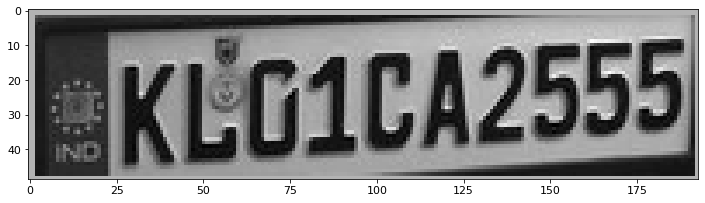

In [20]:
height, width, channel = plate_crop.shape

gray_img = cv2.cvtColor(plate_crop, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 12))
plt.imshow(gray_img, cmap='gray')

### Gaussian Blur, Threshold 설정

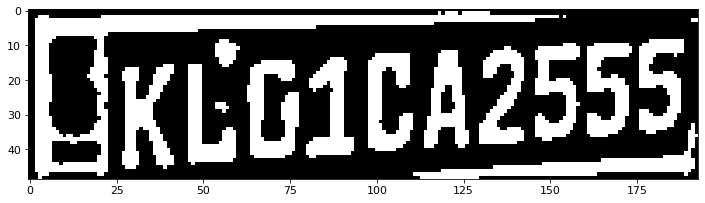

In [21]:
blurred_img = cv2.GaussianBlur(gray_img, ksize=(5, 5), sigmaX=0)

thresh_img = cv2.adaptiveThreshold(
    blurred_img,
    maxValue = 255.0,
    adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType = cv2.THRESH_BINARY_INV,
    blockSize = 19,
    C=9
)

plt.figure(figsize=(12, 12))
plt.imshow(thresh_img, cmap='gray')

### Contour를 확인

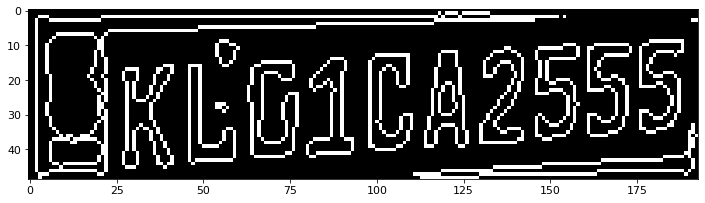

In [22]:
contours, _ = cv2.findContours(
    thresh_img,
    mode = cv2.RETR_LIST,
    method = cv2.CHAIN_APPROX_SIMPLE
)

temp_img = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_img, contours=contours, contourIdx=-1, color=(255, 255,255))

plt.figure(figsize=(12, 12))
plt.imshow(temp_img)

### Contour 중 글자가 아닌 노이즈로 보이는 것은 삭제

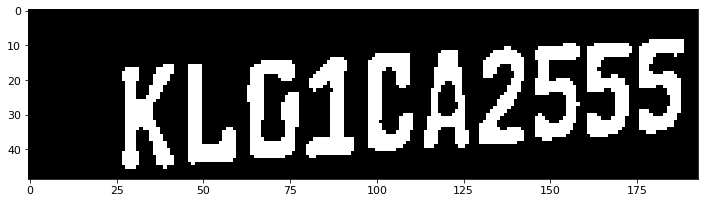

In [23]:
temp_img = np.zeros((height, width, channel), dtype=np.uint8)

MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    area = w * h
    ratio = w / h
    
    if area < MIN_AREA or w < MIN_WIDTH \
    or h < MIN_HEIGHT or ratio < MIN_RATIO or ratio > MAX_RATIO:
        cv2.fillPoly(thresh_img, pts=[contour], color=(0,0,0))
        continue
        
    cv2.rectangle(temp_img, pt1=(x,y), pt2=(x+w,y+h), color=(255,255,255), thickness=2)
    
plt.figure(figsize=(12, 12))
plt.imshow(thresh_img, cmap='gray')

### pytesseract를 이용하여 OCR 작업

KLG1042555


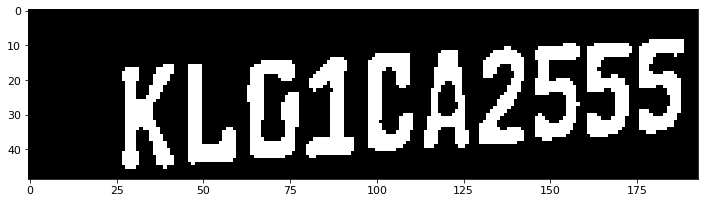

In [24]:
import pytesseract

chars = pytesseract.image_to_string(thresh_img, lang='enm', config='--psm 7 --oem 1')
    
result_chars = ''
has_digit = False
for c in chars:
    if ord('A') <= ord(c) <= ord('z') or c.isdigit():
        if c.isdigit():
            has_digit = True
        result_chars += c

print(result_chars.upper())

plt.figure(figsize=(12, 12))
plt.imshow(thresh_img, cmap='gray')

# plate_chars.append(result_chars)

# if has_digit and len(result_chars) > longest_text:
#     longest_idx = i

# plt.subplot(len(plate_imgs), 1, i+1)
# plt.imshow(temp_img, cmap='gray')

### 위에서 작업한 내용을 Class로 정리

In [25]:
class FindCarPlateNumber:
    def __init__(self, minWidth=2, minHeight=8, minArea=80, minRatio=0.25, maxRatio=1.0):
        self.minWidth = minWidth
        self.minHeight = minHeight
        self.minArea = minArea
        self.minRatio = minRatio
        self.maxRatio = maxRatio
        
        self.model = torch.hub.load('ultralytics/yolov5', 'custom', 
                                    path = '../yolov5/runs/train/exp9/weights/best.pt', 
                                    force_reload=False)
                
    def findLabelsAndCoordinates(self, img):
        results = self.model(img)
        return results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]  # labels, coordinates
    
    def clearImage(self, img):
        
        # Convert to Gray Image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 커널 생성(대상이 있는 픽셀을 강조)
        kernel = np.array([[0, -1, 0],
                            [-1, 9, -1],
                            [0, -1, 0]])

        # 커널 적용 
        gray = cv2.filter2D(gray, -1, kernel) 

        # GaussianBlur
        blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
        
        # AdaptiveThreshold
        thresh = cv2.adaptiveThreshold(
            blurred,
            maxValue = 255.0,
            adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            thresholdType = cv2.THRESH_BINARY_INV,
            blockSize = 19,
            C=9
        )

        # Find Contours And Filtering
        contours, _ = cv2.findContours(
            thresh,
            mode = cv2.RETR_LIST,
            method = cv2.CHAIN_APPROX_SIMPLE
        )
        
        cleared = thresh.copy()

        for contour in contours:
            x,y,w,h = cv2.boundingRect(contour)
            area = w * h
            ratio = w / h

            if area < self.minArea or w < self.minWidth \
            or h < self.minHeight or ratio < self.minRatio or ratio > self.maxRatio:
                cv2.fillPoly(cleared, pts=[contour], color=(0,0,0))

        return cleared
    
    def findPlateCharacters(self, img):
        chars = pytesseract.image_to_string(thresh_img, lang='enm', config='--psm 7 --oem 1')
    
        result_chars = ''
        has_digit = False
        for c in chars:
            if ord('A') <= ord(c) <= ord('z') or c.isdigit():
                if c.isdigit():
                    has_digit = True
                result_chars += c

        return result_chars.upper()

### Class를 이용하여 번호판인식 테스트

In [26]:
anpr = FindCarPlateNumber()

Using cache found in /Users/okchuri/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-9 Python-3.8.13 torch-1.13.0 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


/var/folders/d3/rg33x5mx21z57d1fcv44v7qr0000gn/T/ipykernel_2104/2294506063.py:23: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


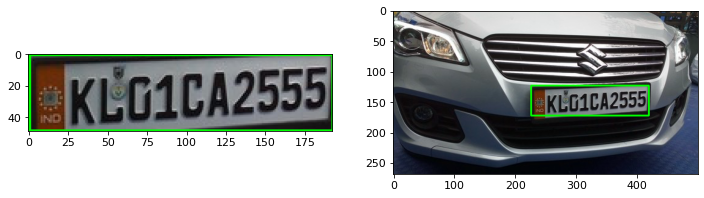

In [27]:
img = cv2.imread('../data/images/Cars0.png')

labels, coordinates = anpr.findLabelsAndCoordinates(img)

width, height = img.shape[1], img.shape[0]

for i in range(len(labels)):
    row = coordinates[i]
    
    x1, y1, x2, y2 = int(row[0].item()*width), int(row[1].item()*height), int(row[2].item()*width), int(row[3].item()*height)
    
    plate_crop = img[int(y1):int(y2), int(x1):int(x2)]
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    fig = plt.figure(figsize=(12, 12))
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(plate_crop, cmap='gray')
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(img, cmap='gray')
    
    plt.show()

In [28]:
cleared = anpr.clearImage(plate_crop)

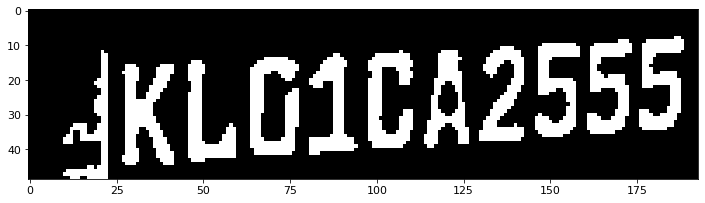

In [29]:
plt.figure(figsize=(12, 12))
plt.imshow(cleared, cmap='gray')

In [30]:
anpr.findPlateCharacters(cleared)

'KLG1042555'

### Intel Mackbook Pro에서 MPS(Metal Performance Shaders) 사용확인

In [31]:
print(f'torch version : {torch.__version__}')
print(f'mps built : {torch.backends.mps.is_built()}')
print(f'mps avail : {torch.backends.mps.is_available()}')

torch version : 1.13.0
mps built : True
mps avail : True


In [32]:
# # Check that MPS is available

# mps_device = "cpu"

# if not torch.backends.mps.is_available():
#     if not torch.backends.mps.is_built():
#         print("MPS not available because the current PyTorch install was not "
#               "built with MPS enabled.")
#     else:
#         print("MPS not available because the current MacOS version is not 12.3+ "
#               "and/or you do not have an MPS-enabled device on this machine.")

# else:
#     mps_device = torch.device("mps")

### MPS를 설정하여 학습을 진행하면 오류 발생, 현재 수정중인 문제로 보임

In [33]:
start_time = timer()

!cd ../yolov5 && python train.py --workers 4 --img 640 --batch 16 --epochs 100 --data "data/plates.yaml" --weights yolov5s.pt --device mps --cache

end_time = timer()

print(f'Training time: {(end_time - start_time):.2f}')

train: weights=yolov5s.pt, cfg=, data=data/plates.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=mps, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=4, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-235-g75728bb Python-3.8.13 torch-1.13.0 MPS

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate

https://discuss.pytorch.org/t/mps-is-not-working-even-with-nightly-conda-and-pip3-versions/160168

In [9]:
start_time = timer()

!cd ../yolov5 && python train.py --workers 24 --img 640 --batch 16 --epochs 20 --data "data/plates.yaml" --weights yolov5s.pt --cache

end_time = timer()

print(f'Training time: {(end_time - start_time):.2f}')

train: weights=yolov5s.pt, cfg=, data=data/plates.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 39 (delta 25), reused 30 (delta 17), pack-reused 0
오브젝트 묶음 푸는 중: 100% (39/39), 19.87 KiB | 442.00 KiB/s, 완료.
https://github.com/ultralytics/yolov5 URL에서
   8406465..a1b687e  exp10-m-base       -> origin/exp10-m-base
 * [새로운 브랜치]   exp_proto_upsample -> origin/

### Intel Mackbook Pro에서 MSP를 활성화하여도 특별히 속도향상이 없었다.

### Mackbook에서 CPU보다 MPS(GPU)가 더 느리다???
### https://github.com/pytorch/pytorch/issues/77799

In [3]:
import timeit

a_cpu = torch.rand(1000, device='cpu')
b_cpu = torch.rand((1000, 1000), device='cpu')
a_mps = torch.rand(1000, device='mps')
b_mps = torch.rand((1000, 1000), device='mps')

print('cpu', timeit.timeit(lambda: a_cpu @ b_cpu, number=100_000))
print('mps', timeit.timeit(lambda: a_mps @ b_mps, number=100_000))

cpu 10.509896870000006
mps 87.01297328400001
